# Subspace randomized bencharmking

Subspace randomized bencharmking (SRB) is a variant of randomized benchmarking to measure the performance of the Molmer-Sorenson (or ZZ) gate across the symmetric subspace of two ions. The symmetric subspace forms a qutrit (three-dimensional Hilbert space) where we perform standard randomized benchmarking. We use optimal control (see __[arXiv:1011.4874](https://arxiv.org/pdf/1011.4874.pdf)__ for more info) to generate the needed qutrit Clifford gates by compiling the Molmer-Sorenson gates plus global single-qubit gates with arbitrary amplitude and phase.

This notebook covers how to run the `sub_bench.py` for simulation and experimental data loading as well as other features in the script for analysis.

Some notes:
- The leakage decay (or trace decay curve) has occasionally has fitting problems, which causes high variances in the bootstrap resampling.
- The SRB paper has a full description of our leakage fitting method



## Initializing randomized benchmarking experiment 
We first create a blank instance of `SubBench` and then use the `build_experiments` method to create the sequences of random gates. 

The first two args in `build_experiments` determine the length of sequences, and number of repitions per sequence, which are generally experiment dependent. A good rule of thumb is to pick 'seq_len' as exponentially distrubted between 1 and 1/(error) and `seq_reps = 100`. One option is to set `seq_len = fib_numbers(1/error)`.

The next arg `lname` specifies the type of optimal control pickle file to use to generate the gates. These files are included in srb\control_pulses and specify the micro-wave phases for single qubit gates needed to generate either all 216 qutrit Clifford gates or a sufficient generating set. Current options (both saved in diagnostics directory): <br>
- `ZZ_fixed3.pkl`: uses global single-qubit gates with arbitrary amplitude and phase, and 3 ZZ gates to generate all 216 qutrit Cliffords <br>
- `ZZ_fixed3n2.pkl`: uses global single-qubit gates with $\pi/2$ amplitude and arbitrary phase, and 3 ZZ gates to generate all 216 qutrit Cliffords <br>
- `XX_fixed3.pkl`: uses global single-qubit gates with arbitrary amplitude and phase, and 3 XX gates to generate all 216 qutrit Cliffords <br>
- `XX_fixed3n2.pkl`: uses global single-qubit gates with $\pi/2$ amplitude and arbitrary phase, and 3 XX gates to generate all 216 qutrit Cliffords <br>
- `YY_fixed3.pkl`: uses global single-qubit gates with arbitrary amplitude and phase, and 3 YY gates to generate all 216 qutrit Cliffords <br>
- `YY_fixed3n2.pkl`: uses global single-qubit gates with $\pi/2$ amplitude and arbitrary phase, and 3 YY gates to generate all 216 qutrit Cliffords <br>

The next two args determine if the experiments are output in a random order (`randomize_exp=True`) and if they are saved to a seperate pickle file (`save_seq=True`).

The final arg determines if the number of possible Cliffords should be doubled to include Cliffords that put the opposite sign on the anti-symmetric subspace `add_reverse=True`. This also  increases the average number of `ZZ` gates per Clifford. We think this shouldn't matter so usually we set `add_reverse=False`.

In [1]:
import numpy as np
from srb.methods import sub_bench as srb

seed = 0 # random seed for numpy random number generator

exp1 = srb.SubBench(seed)
control_str = exp1.build_experiments(2**np.arange(10), 100, 
                                    lname='ZZ_fixed3n2.pkl',
                                    randomize_exp=False,
                                    save_seq=False,
                                    add_reverse=True)

The output `control_str` is a list of control sequences for each sub experiment. For example, for the first sublist in `control_str` generated above corresponds to the first length 2 experiment:

In [2]:
control_str[0]

['0.5pi_0.27526842pi',
 '0.5pi_1.6836584pi',
 '0.5pi_1.0536429pi',
 '0.5pi_0.73657908pi',
 'ZZ',
 '0.5pi_1.0058295pi',
 '0.5pi_1.1474793pi',
 '0.5pi_1.8813266pi',
 '0.5pi_0.41004232pi',
 'ZZ',
 '0.5pi_0.2040955pi',
 '0.5pi_0.59164745pi',
 '0.5pi_0.21727845pi',
 '0.5pi_1.4559187pi',
 'ZZ',
 '0.5pi_0.97395152pi',
 '0.5pi_1.214541pi',
 '0.5pi_0.13231512pi',
 '0.5pi_0.047998916pi',
 '0.5pi_0.57952728pi',
 '0.5pi_0.37790153pi',
 '0.5pi_0.7896316pi',
 '0.5pi_1.6189635pi',
 'ZZ',
 '0.5pi_1.0195428pi',
 '0.5pi_1.1280802pi',
 '0.5pi_0.53687121pi',
 '0.5pi_1.8109065pi',
 'ZZ',
 '0.5pi_1.2595983pi',
 '0.5pi_1.9016524pi',
 '0.5pi_0.6833288pi',
 '0.5pi_0.22102374pi',
 'ZZ',
 '0.5pi_1.6762075pi',
 '0.5pi_0.50198698pi',
 '0.5pi_1.0459551pi',
 '0.5pi_0.29026152pi']

Each control string in the sublist corresponds either <br>
1. Collective single-qubit $U(\theta, \phi) = \exp[-i \tfrac{\theta}{2}(X \cos(\phi) + Y \sin(\phi))^{\otimes 2}]$ gate with written as `'<amp>pi_<phs>pi'` where `<amp>` = $\theta$ and `<phs>` = $\phi$ <br>
2. Entangling gate `'ZZ'` with $U_{ZZ} = \exp[-i \tfrac{\pi}{4} ZZ]$, `'XX'` with $U_{XX} = \exp[-i \tfrac{\pi}{4} XX]$, or `'YY'` with $U_{YY} = \exp[-i \tfrac{\pi}{4} YY]$<br>

These sequences then can be run on the experiment and produce a pandas DataFrame in the format discussed below.


## Generating reference histograms



In [3]:
from srb.methods import detector_tomography as texp
from srb.models import qutip_models as qm
from srb.funcs import bin_data_funcs as bd
import numpy as np

temps = texp.DetectTomo()
control_str2 = temps.build_experiments('uW', save_seq=False)
    
data2 = qm.nbright_sim(temps, trials=10000, mean_counts=[0.1,10,20],
                            error_state={'nqubits':2, 'etype':'dep', 'magnitude':0},
                            error_1q={'nqubits':1, 'etype':'dep', 'magnitude':0},
                            error_2q={'nqubits':2, 'etype':'dep', 'magnitude':0},
                            error_meas={'nqubits':2, 'etype':'dep', 'magnitude':0})

template = bd.template_histograms(data2)
Qmat = bd.detector_tomography(data2, thresholds=[0,2,15,np.inf])

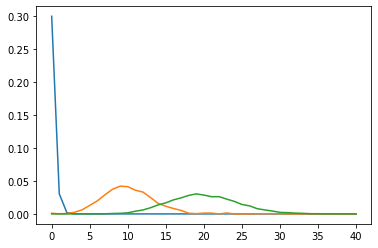

In [4]:
import matplotlib.pyplot as plt
plt.plot(template[0])
plt.plot(template[1])
plt.plot(template[2])

## Simulating data
To simulate the data, we use the `qutip_models` module. In the function `nbright_sim` (for simulating 2 ions in a measurement zone) we specify the number of trials per sequence, mean photon counts, thresholds (bin edges), and errors. The method allows for different error channels for state prep (`error_state`), single-qubit gates (`error_1q`), two-qubit gates (`error_2q`), and measurement (`error_meas`). Each error is a tuple where the first element is a string that specifies the type of error and the next elements specifying the strength of the error. Errors are generated in `error_processes.py`. 

In [5]:
from srb.models import qutip_models as qm

data = qm.nbright_sim(exp1, trials=100, mean_counts=[0.1,10,20],
                            error_state={'nqubits':exp1.nqubits, 'etype':'dep', 'magnitude':1e-4},
                            error_1q={'nqubits':1, 'etype':'dep', 'magnitude':1e-4},
                            error_2q={'nqubits':2, 'etype':'dep', 'magnitude':1e-3},
                            error_meas={'nqubits':exp1.nqubits, 'etype':'dep', 'magnitude':1e-4})

The `data` is returned in the format that the `exp1` object can read to analyze the results. The columns are labeled `RB_ID` for the RB ID number of each sequence, `ShotID` for each shot in the experiment, and `Count` for the number of photons counted.

In [6]:
data

ShotID  Count  RB_ID
0        0   14.0      0
1        1    8.0      0
2        2   13.0      0
3        3   14.0      0
4        4   13.0      0
..     ...    ...    ...
95      95   19.0    999
96      96   23.0    999
97      97   26.0    999
98      98   14.0    999
99      99   26.0    999

[100000 rows x 3 columns]

## Loading data
To load data into a `SubBench` instance we use the `load_data` method. To show how this works let's use the data generated from `nbright_sim`. We need to first bin this raw photon count data into by the `threshold_counts` funciton in `bin_data_funcs.py`. To load the data, we have to specify the names of the detectors, which correspond to the names of the columns of the pandas dataframe that contain the count information. 

In [7]:
from srb.funcs import bin_data_funcs as bd

hists = bd.threshold_counts(data, bin_rule=bd.nbright_bins, thresholds=[0,2,15,np.inf])
exp1.load_data(hists)

## Analyzing data
The instance exp1 now contains randomly generated SRB data ready for analysis. For standard analysis, we do a least-squares fitting of the data to the curve $\overline{p}_S(\ell) = A r^{\ell} + \tfrac{1}{3}$. For the leakage analysis, we do a least-squares fitting to $\overline{p}_L(\ell) = A t^{\ell} + B$. To perform these fits, we use the `analyze_data` method. 

The parameter $r$ is called the 'standard decay parameter' and the parameter $t$ is called the leakage decay parameter. They relate to the extended-subspace fidelity of the Clifford gates. The parameters $A$ and $B$ are related to all the errors (state preparation,  one and two-qubit gates, and measurement errors).

We additionally perform a semi-parametric bootstrap resample to estimate confidence intervals of the fidelity and plot the decay curve. Finally, the method `output_str` gives a summary of all the relevant information from the experiment and fit.


###############################################################################
2-qubit subspace randomized benchmarking info, v = SubBench_v1.0
###############################################################################

Sequence info 
-------------------------------------------------------------------------------
Random seed: 0
Gate file used: ZZ_fixed3n2.pkl
Number of random sequences per length:
1: 100
2: 100
4: 100
8: 100
16: 100
32: 100
64: 100
128: 100
256: 100
512: 100
final measurements (pauli indices): [0 1 2 3 4 5 6 7 8]


Data summary  (loaded 20191030-112735)
-------------------------------------------------------------------------------
Avg. survival frequency +/- standard error of mean:
1: 0.9355 +/- 0.0045 
2: 0.9160 +/- 0.0049 
4: 0.9235 +/- 0.0051 
8: 0.8961 +/- 0.0047 
16: 0.8791 +/- 0.0050 
32: 0.8212 +/- 0.0054 
64: 0.7286 +/- 0.0061 
128: 0.6051 +/- 0.0071 
256: 0.4601 +/- 0.0102 
512: 0.3579 +/- 0.0109 


Fit info 
-------------------------------------------

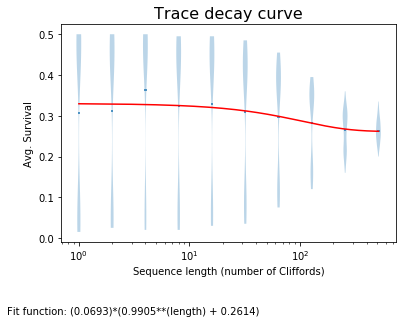

In [8]:
exp1.analyze_data(asympt_freq=1/3)
exp1.bootstrap(100)
exp1.plot_survival()
exp1.plot_trace()
print(exp1.output_str())

## Saving and loading instance
Now say we generated `exp1` and took data but now we want to save everything for future analysis. We use the `output_dict` method to create a dictionary of all the relevant info about `exp1` and either save it as a pickle file (specify the name as an arg) or just keep it as variable. We can then use the `load_experiment` method to input all this info into a new instance of `SubBench`.

In [9]:
exp1_dict = exp1.output_dict()
exp1_new = srb.SubBench(seed=0)
exp1_new.load_experiments(exp1_dict)